In [2]:
from typing import List
import numpy as np
import xarray as xr
from pathlib import Path
from winter_year import WinterYear


winter_year = WinterYear(2023, 2024)
time_series_folder = '../output_folder/version_3'

s2_filename = 'WY_2023_2024_S2_res_375m.nc'
mf_filename = 'WY_2023_2024_SNPP_meteofrance_res_375m.nc'
nasa_l3_filename = 'WY_2023_2024_SNPP_nasa_l3_res_375m.nc'
nasa_pseudo_l3_filename = 'WY_2023_2024_SNPP_nasa_pseudo_l3_res_375m.nc'
s2_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(s2_filename))
meteofrance_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(mf_filename))
nasa_l3_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(nasa_l3_filename))
nasa_pseudo_l3_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(nasa_pseudo_l3_filename))


def find_common_days(time_series_list: List[xr.Dataset]):
    common_days_old = time_series_list[0]["time"]
    for i in range(1,len(time_series_list)):
        common_days_new= np.intersect1d(common_days_old, time_series_list[i]["time"])
        common_days_old = common_days_new
    return common_days_new

common_days = find_common_days(time_series_list=[s2_time_series, meteofrance_time_series, nasa_l3_time_series, nasa_pseudo_l3_time_series])
s2_time_series = s2_time_series.sel(time=common_days)
meteofrance_time_series = meteofrance_time_series.sel(time=common_days)
nasa_l3_time_series = nasa_l3_time_series.sel(time=common_days)
nasa_pseudo_l3_time_series = nasa_pseudo_l3_time_series.sel(time=common_days)
products_to_compare = {'Météo-France': meteofrance_time_series, 'NASA L3': nasa_l3_time_series, 'NASA pseudo L3': nasa_pseudo_l3_time_series}

In [3]:
from typing import List
from datetime import datetime

def find_common_days(time_series_list: List[xr.Dataset]):
    common_days_old = time_series_list[0]["time"]
    for i in range(1,len(time_series_list)):
        common_days_new= np.intersect1d(common_days_old, time_series_list[i]["time"])
        common_days_old = common_days_new
    return common_days_new
def daily_average(data_array: xr.DataArray):
    time_coord = data_array.coords['time'].values
    month_datetime = datetime(int(str(time_coord[0])[:4]), int(str(time_coord[0])[5:7]), int(str(time_coord[0])[8:10]))
    return xr.DataArray([data_array.sum().values / len(time_coord)], coords={'time': [month_datetime]})

def difference_array_to_bias_rmse(difference_array: np.array):
    biais = np.nanmean(difference_array)
    rmse = np.sqrt(np.nanmean((difference_array- biais)**2))
    return biais, rmse

In [6]:
from typing import Dict

from products.classes import METEOFRANCE_CLASSES, NASA_CLASSES, S2_CLASSES
import pandas as pd
from datetime import datetime

valid_ranges_dict = {'Sentinel-2': {'fsc_max': S2_CLASSES['snow_cover'][-1]},
                     'Météo-France': {'fsc_max': METEOFRANCE_CLASSES['snow_cover'][-1]},
                     'NASA L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]},
                     'NASA pseudo L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]}}


def compute_monthly_bias_rmse_fsc(ref_time_series: Dict[str, xr.Dataset], time_series_to_compare: Dict[str, xr.Dataset], fsc_threshold: float = 0):

    months = pd.date_range("2023-10-01",periods=12,freq="ME")
    months = [datetime(year=month.year, month=month.month, day=1) for month in months]
    errors = xr.Dataset({'biais': xr.DataArray(np.nan, dims=('time', 'product', 'ref_fsc'),coords={'time':months, 'product': list(products_to_compare.keys()), 'ref_fsc': ['0', '1-99','1-100', 'all']}),
                    'unbiased_RMSD': xr.DataArray(np.nan, dims=('time', 'product', 'ref_fsc'),coords={'time':months, 'product': list(products_to_compare.keys()), 'ref_fsc': ['0', '1-99','1-100', 'all']})})

    for month in months:
        print("Processing month no.", month.strftime("%Y-%m"))
        ref_snow_cover = list(ref_time_series.values())[0].data_vars['snow_cover_fraction'].sel(time=month.strftime("%Y-%m"))
        ref_fsc_max = valid_ranges_dict[list(ref_time_series.keys())[0]]['fsc_max']
        ref_mask = ref_snow_cover  <= ref_fsc_max 
        ref_snow_cover = ref_snow_cover.where(ref_mask) / ref_fsc_max
        for product_name, product in time_series_to_compare.items():
            print("Processing product", product_name)
            product_snow_cover = product.data_vars['snow_cover_fraction'].sel(time=month.strftime("%Y-%m")) 
            if fsc_threshold>0:
                product_snow_cover.where(product_snow_cover  >= fsc_threshold, 0)

            product_fscmax = valid_ranges_dict[product_name]['fsc_max']
            product_mask = (product_snow_cover  < product_fscmax) 
            product_snow_cover = product_snow_cover.where(product_mask) / product_fscmax

            difference = product_snow_cover - ref_snow_cover
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, 'all'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, 'all'] = rmse
            print('all',biais*100, rmse*100)
            difference = product_snow_cover.where(ref_snow_cover==0) - ref_snow_cover.where(ref_snow_cover==0)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '0'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '0']= rmse
            print('0',biais*100, rmse*100)
            difference = product_snow_cover.where(ref_snow_cover>0) - ref_snow_cover.where(ref_snow_cover>0)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '1-100']  = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '1-100'] = rmse
            print('1-100',biais*100, rmse*100)
            difference = product_snow_cover.where(ref_snow_cover>0).where(ref_snow_cover < ref_fsc_max) - ref_snow_cover.where(ref_snow_cover>0).where(ref_snow_cover < ref_fsc_max)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '1-99'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '1-99'] = rmse
            print('1-99',biais*100, rmse*100)
    return errors

errors_fsc = compute_monthly_bias_rmse_fsc(ref_time_series={"Sentinel-2": s2_time_series}, time_series_to_compare=products_to_compare, fsc_threshold=0)
errors_fsc.to_netcdf(f'{time_series_folder}/WY_2023_2024_SNPP_errors_fsc.nc')

Processing month no. 2023-10
Processing product Météo-France
all -0.04227853 1.9546618
0 0.010532584 0.6087597
1-100 -14.770275 27.355146
1-99 -14.770275 27.355146
Processing product NASA L3
all 0.008930477 1.1614809
0 0.02355375 0.7077452
1-100 -8.173564 20.220203
1-99 -8.173564 20.220203
Processing product NASA pseudo L3
all 0.022687407 2.1624827
0 0.054815084 1.3181404
1-100 -9.812452 28.41298
1-99 -9.812452 28.41298
Processing month no. 2023-11
Processing product Météo-France
all 0.8065886 13.3398485
0 0.51438636 5.445514
1-100 2.618961 33.074917
1-99 2.618961 33.074917
Processing product NASA L3
all 0.76408947 7.111189
0 0.48110318 3.9089189
1-100 5.7279806 25.368053
1-99 5.7279806 25.368053
Processing product NASA pseudo L3
all 1.2263453 9.855179
0 0.89512813 6.1506224
1-100 5.349292 28.580645
1-99 5.349292 28.580645
Processing month no. 2023-12
Processing product Météo-France
all 1.1169074 12.36098
0 0.5974562 6.0295205
1-100 4.1481214 28.661776
1-99 4.1481214 28.661776
Processi

In [4]:
from typing import Dict

from products.classes import METEOFRANCE_CLASSES, NASA_CLASSES, S2_CLASSES
import pandas as pd
from datetime import datetime

valid_ranges_dict = {'Sentinel-2': {'fsc_max': S2_CLASSES['snow_cover'][-1]},
                     'Météo-France': {'fsc_max': METEOFRANCE_CLASSES['snow_cover'][-1]},
                     'NASA L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]},
                     'NASA pseudo L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]}}


def compute_monthly_bias_rmse_fsc(ref_time_series: Dict[str, xr.Dataset], time_series_to_compare: Dict[str, xr.Dataset], fsc_threshold: float = 0):

    months = pd.date_range("2023-10-01",periods=12,freq="ME")
    months = [datetime(year=month.year, month=month.month, day=1) for month in months]
    errors = xr.Dataset({'biais': xr.DataArray(np.nan, dims=('time', 'product', 'sensor_zenith'),coords={'time':months, 'product': list(products_to_compare.keys()), 'sensor_zenith': ['0-15', '15-30','30-45','45-60','>60', 'all']}),
                    'unbiased_RMSD': xr.DataArray(np.nan, dims=('time', 'product', 'sensor_zenith'),coords={'time':months, 'product': list(products_to_compare.keys()), 'sensor_zenith': ['0-15', '15-30','30-45','45-60','>60', 'all']})})

    for month in months:
        print("Processing month no.", month.strftime("%Y-%m"))
        ref_snow_cover = list(ref_time_series.values())[0].data_vars['snow_cover_fraction'].sel(time=month.strftime("%Y-%m"))
        ref_fsc_max = valid_ranges_dict[list(ref_time_series.keys())[0]]['fsc_max']
        ref_mask = ref_snow_cover  <= ref_fsc_max 
        ref_snow_cover = ref_snow_cover.where(ref_mask) / ref_fsc_max
        for product_name, product in time_series_to_compare.items():
            print("Processing product", product_name)
            product_snow_cover = product.data_vars['snow_cover_fraction'].sel(time=month.strftime("%Y-%m")) 
            product_vza = product.data_vars['sensor_zenith'].sel(time=month.strftime("%Y-%m")) 
            if fsc_threshold>0:
                product_snow_cover.where(product_snow_cover  >= fsc_threshold, 0)

            product_fscmax = valid_ranges_dict[product_name]['fsc_max']
            product_mask = (product_snow_cover  < product_fscmax) 
            product_snow_cover = product_snow_cover.where(product_mask) / product_fscmax
            product_vza = product_vza.where(product_mask)

            difference = product_snow_cover - ref_snow_cover
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, 'all'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, 'all'] = rmse
            print('all',biais*100, rmse*100)
            mask_inf = product_vza >=0
            mask_sup = product_vza <15
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '0-15'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '0-15']= rmse
            print('0-15',biais*100, rmse*100)
            mask_inf = product_vza >=15
            mask_sup = product_vza <30
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '15-30'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '15-30']= rmse
            print('15-30',biais*100, rmse*100)
            mask_inf = product_vza >=30
            mask_sup = product_vza <45
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '30-45'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '30-45']= rmse
            print('30-45',biais*100, rmse*100)
            mask_inf = product_vza >=45
            mask_sup = product_vza <60
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '45-60'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '45-60']= rmse
            print('45-60',biais*100, rmse*100)
            mask_inf = product_vza >=60
            difference = product_snow_cover.where(mask_inf) - ref_snow_cover.where(mask_inf)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '>60'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '>60']= rmse
            print('>60',biais*100, rmse*100)
    return errors
products_to_compare = {'Météo-France': meteofrance_time_series, 'NASA pseudo L3': nasa_pseudo_l3_time_series}
errors_vza = compute_monthly_bias_rmse_fsc(ref_time_series={"Sentinel-2": s2_time_series}, time_series_to_compare=products_to_compare, fsc_threshold=0)
errors_vza.to_netcdf(f'{time_series_folder}/WY_2023_2024_SNPP_errors_vza.nc')

Processing month no. 2023-10
Processing product Météo-France
all -0.04227853 1.9546618
0-15 0.0 0.0
15-30 -0.010440334 1.270464
30-45 -0.03518387 1.7030259
45-60 -0.062076777 2.0368547
>60 -0.17328228 4.1600986
Processing product NASA pseudo L3
all 0.022687407 2.1624827
0-15 0.0721301 1.6028007
15-30 -0.009861827 1.0193911
30-45 0.013269357 1.5522742
45-60 0.04167142 2.824075
>60 0.4101162 8.878021
Processing month no. 2023-11
Processing product Météo-France
all 0.8065886 13.3398485
0-15 0.33781454 4.927942
15-30 1.2412901 11.769785
30-45 0.80288213 12.075505
45-60 0.9404205 16.427929
>60 0.58988434 21.770264
Processing product NASA pseudo L3
all 1.2263453 9.855179
0-15 0.11153389 3.1125977
15-30 0.3472379 7.4122763
30-45 0.93103033 9.477566
45-60 1.9046036 11.360164
>60 8.64633 21.936844
Processing month no. 2023-12
Processing product Météo-France
all 1.1169074 12.36098
0-15 2.239732 11.6115
15-30 0.67974424 9.182713
30-45 1.1922938 13.135153
45-60 0.9580725 10.29591
>60 0.93325907 19

In [3]:
from typing import Dict

from products.classes import METEOFRANCE_CLASSES, NASA_CLASSES, S2_CLASSES
import pandas as pd
from datetime import datetime

valid_ranges_dict = {'Sentinel-2': {'fsc_max': S2_CLASSES['snow_cover'][-1]},
                     'Météo-France': {'fsc_max': METEOFRANCE_CLASSES['snow_cover'][-1]},
                     'NASA L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]},
                     'NASA pseudo L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]}}


def compute_monthly_bias_rmse_fsc(ref_time_series: Dict[str, xr.Dataset], time_series_to_compare: Dict[str, xr.Dataset], fsc_threshold: float = 0):

    months = pd.date_range("2023-10-01",periods=12,freq="ME")
    months = [datetime(year=month.year, month=month.month, day=1) for month in months]
    errors = xr.Dataset({'biais': xr.DataArray(np.nan, dims=('time', 'product', 'sensor_zenith'),coords={'time':months, 'product': list(products_to_compare.keys()), 'sensor_zenith': ['0-15', '15-30','30-45','45-60','>60', 'all']}),
                    'unbiased_RMSD': xr.DataArray(np.nan, dims=('time', 'product', 'sensor_zenith'),coords={'time':months, 'product': list(products_to_compare.keys()), 'sensor_zenith': ['0-15', '15-30','30-45','45-60','>60', 'all']})})

    for month in months:
        print("Processing month no.", month.strftime("%Y-%m"))
        ref_snow_cover = list(ref_time_series.values())[0].data_vars['snow_cover_fraction'].sel(time=month.strftime("%Y-%m"))
        ref_fsc_max = valid_ranges_dict[list(ref_time_series.keys())[0]]['fsc_max']
        ref_mask_sup = ref_snow_cover  <= ref_fsc_max 
        ref_mask_inf = ref_snow_cover>0
        ref_snow_cover = ref_snow_cover.where(ref_mask_sup).where(ref_mask_inf) / ref_fsc_max
        for product_name, product in time_series_to_compare.items():
            print("Processing product", product_name)
            product_snow_cover = product.data_vars['snow_cover_fraction'].sel(time=month.strftime("%Y-%m")) 
            product_vza = product.data_vars['sensor_zenith'].sel(time=month.strftime("%Y-%m")) 
            if fsc_threshold>0:
                product_snow_cover.where(product_snow_cover  >= fsc_threshold, 0)

            product_fscmax = valid_ranges_dict[product_name]['fsc_max']
            product_mask = (product_snow_cover  < product_fscmax) 
            product_snow_cover = product_snow_cover.where(product_mask)/ product_fscmax
            product_vza = product_vza.where(product_mask)

            difference = product_snow_cover - ref_snow_cover
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, 'all'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, 'all'] = rmse
            print('all',biais*100, rmse*100)
            mask_inf = product_vza >=0
            mask_sup = product_vza <15
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '0-15'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '0-15']= rmse
            print('0-15',biais*100, rmse*100)
            mask_inf = product_vza >=15
            mask_sup = product_vza <30
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '15-30'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '15-30']= rmse
            print('15-30',biais*100, rmse*100)
            mask_inf = product_vza >=30
            mask_sup = product_vza <45
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '30-45'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '30-45']= rmse
            print('30-45',biais*100, rmse*100)
            mask_inf = product_vza >=45
            mask_sup = product_vza <60
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '45-60'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '45-60']= rmse
            print('45-60',biais*100, rmse*100)
            mask_inf = product_vza >=60
            difference = product_snow_cover.where(mask_inf) - ref_snow_cover.where(mask_inf)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '>60'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '>60']= rmse
            print('>60',biais*100, rmse*100)
    return errors
products_to_compare = {'Météo-France': meteofrance_time_series, 'NASA pseudo L3': nasa_pseudo_l3_time_series}
errors_vza_positive_fsc = compute_monthly_bias_rmse_fsc(ref_time_series={"Sentinel-2": s2_time_series}, time_series_to_compare=products_to_compare, fsc_threshold=0)
errors_vza_positive_fsc.to_netcdf(f'{time_series_folder}/WY_2023_2024_SNPP_errors_vza_positive_fsc.nc')

Processing month no. 2023-10
Processing product Météo-France
all -14.770275 27.355146


/tmp/ipykernel_6091/4225676704.py:16: RuntimeWarning: Mean of empty slice
  biais = np.nanmean(difference_array)
/tmp/ipykernel_6091/4225676704.py:17: RuntimeWarning: Mean of empty slice
  rmse = np.sqrt(np.nanmean((difference_array- biais)**2))


0-15 nan nan
15-30 -6.2932363 22.557335
30-45 -11.898158 22.853838
45-60 -24.049047 32.46015
>60 -22.00593 32.48974
Processing product NASA pseudo L3
all -9.812452 28.41298
0-15 -4.9999995 13.509255
15-30 -7.249889 18.247625
30-45 -6.301271 21.321096
45-60 -20.152184 35.727997
>60 -8.749865 40.50912
Processing month no. 2023-11
Processing product Météo-France
all 2.618961 33.074917
0-15 9.929488 28.529259
15-30 6.2104044 30.149948
30-45 3.2923281 29.984137
45-60 2.9348922 35.475513
>60 -1.6896622 39.256985
Processing product NASA pseudo L3
all 5.349292 28.580645
0-15 5.2556825 28.016966
15-30 0.9038225 27.076097
30-45 4.516775 27.360321
45-60 8.785777 29.810658
>60 10.023768 31.406164
Processing month no. 2023-12
Processing product Météo-France
all 4.1481214 28.661776
0-15 9.950024 22.778887
15-30 3.9491377 25.140202
30-45 3.548334 27.877447
45-60 3.3349926 29.982397
>60 -0.5537498 34.20908
Processing product NASA pseudo L3
all 5.7413144 29.257254
0-15 11.073374 30.31469
15-30 -1.47374

/tmp/ipykernel_6091/4225676704.py:16: RuntimeWarning: Mean of empty slice
  biais = np.nanmean(difference_array)
/tmp/ipykernel_6091/4225676704.py:17: RuntimeWarning: Mean of empty slice
  rmse = np.sqrt(np.nanmean((difference_array- biais)**2))


0-15 nan nan
15-30 nan nan
30-45 -12.796876 31.308159
45-60 -4.257957 24.955654
>60 -28.468748 37.193523
Processing product NASA pseudo L3
all -3.4657001 24.693142
0-15 -2.0 0.0
15-30 -24.624998 38.8553
30-45 0.08219179 24.86792
45-60 -3.5137794 24.626701
>60 -27.780643 32.21085


In [16]:
xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_375m_errors_fsc.nc')

<xarray.Dataset> Size: 3kB
Dimensions:        (time: 12, product: 3, ref_fsc: 4)
Coordinates:
  * time           (time) datetime64[ns] 96B 2023-10-01 ... 2024-09-01
  * product        (product) <U14 168B 'Météo-France' 'NASA L3' 'NASA pseudo L3'
  * ref_fsc        (ref_fsc) <U5 80B '0' '1-99' '1-100' 'all'
Data variables:
    biais          (time, product, ref_fsc) float64 1kB ...
    unbiased_RMSD  (time, product, ref_fsc) float64 1kB ...

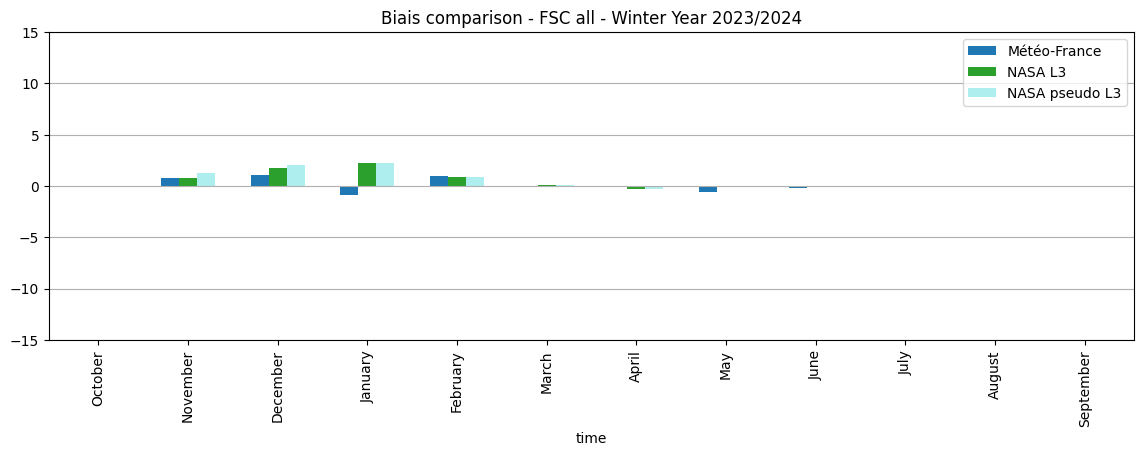

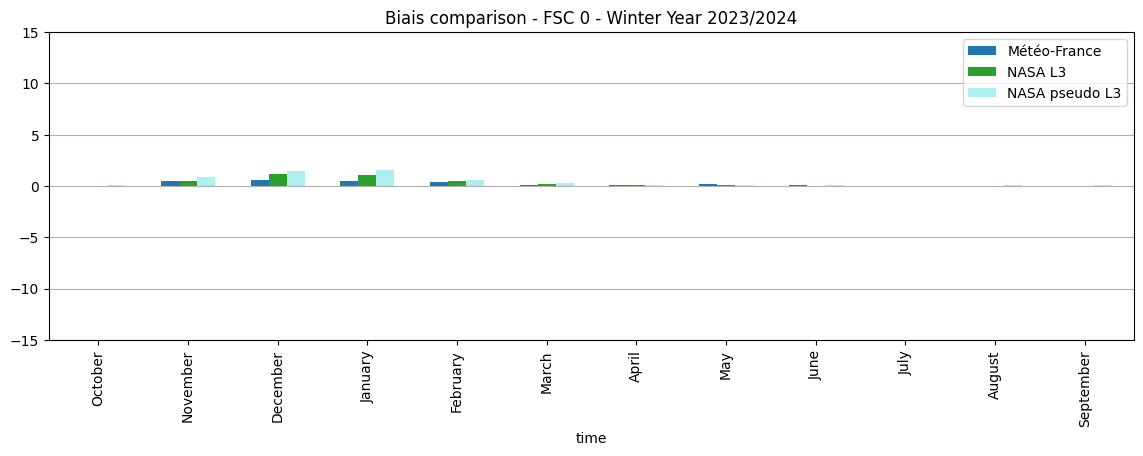

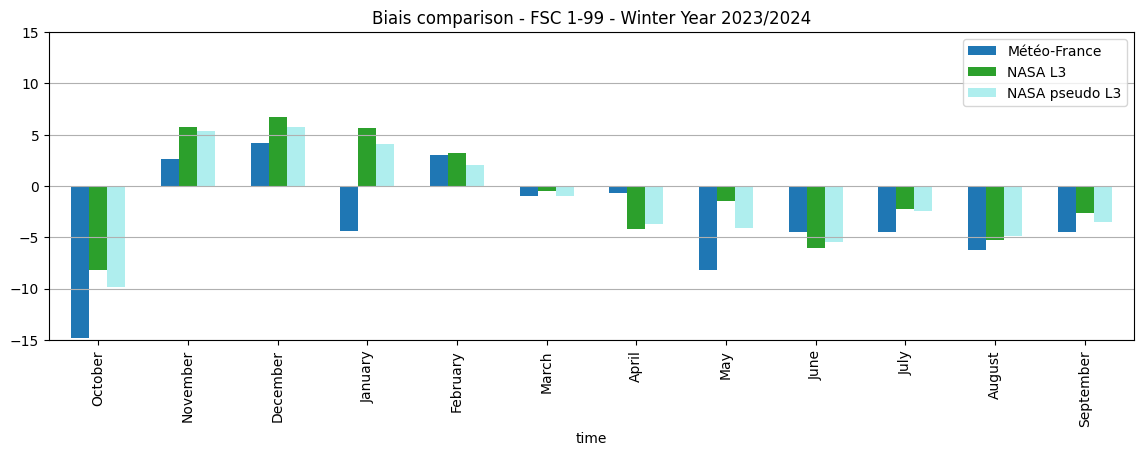

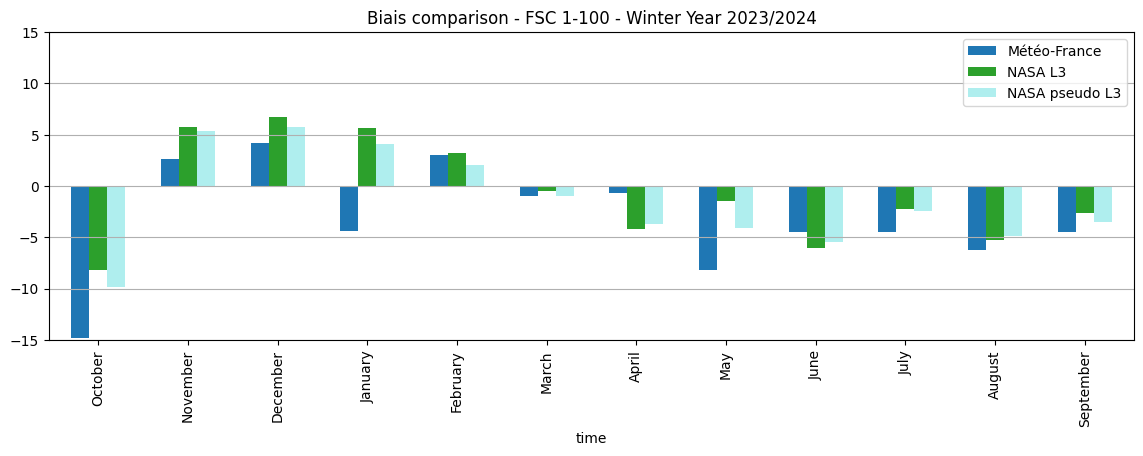

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

errors_fsc = xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_375m_errors_fsc.nc')*100


for fsc_class in ['all','0', '1-99','1-100']:
    errors_fsc_class = errors_fsc.data_vars['biais'].sel(ref_fsc=fsc_class).sortby('time')
    df = pd.DataFrame({'Météo-France': errors_fsc_class.sel(product='Météo-France').to_pandas(), 
                        'NASA L3': errors_fsc_class.sel(product='NASA L3').to_pandas(),
                        'NASA pseudo L3': errors_fsc_class.sel(product='NASA pseudo L3').to_pandas()
                    })

    df.index = df.index.strftime("%B")
    df.plot.bar(figsize=(14,4), color=('tab:blue', 'tab:green','paleturquoise'), width=0.6, title=f'Biais comparison - FSC {fsc_class} - Winter Year 2023/2024')
    plt.ylim([-15,15])
    plt.grid(True,axis='y')

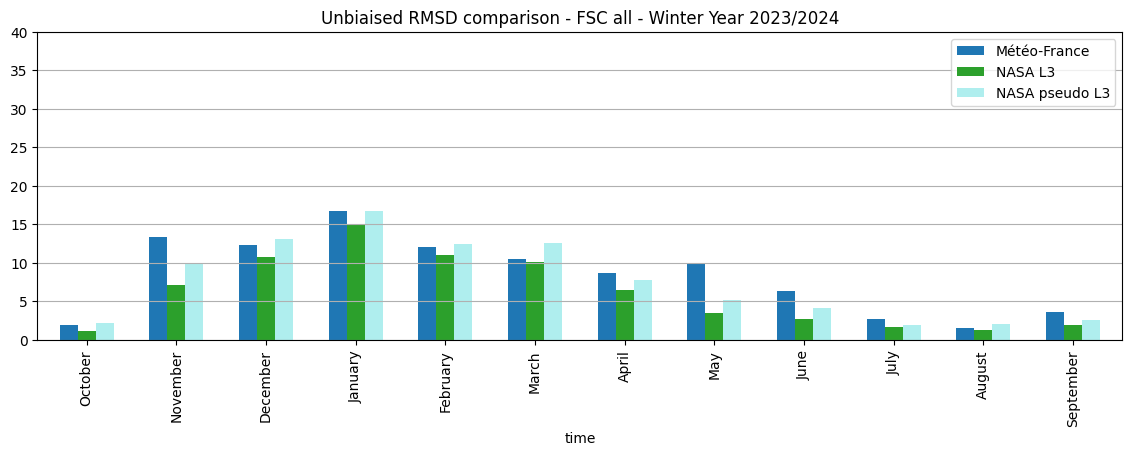

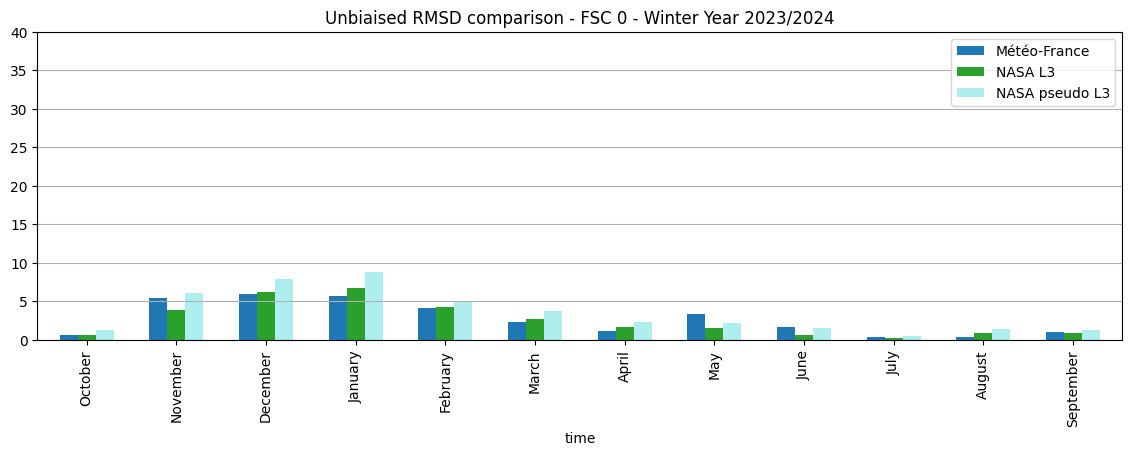

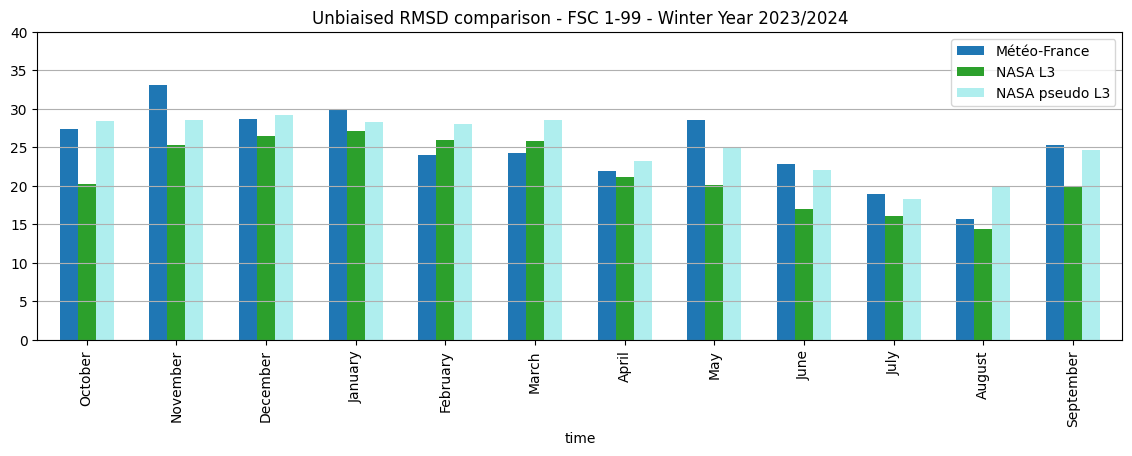

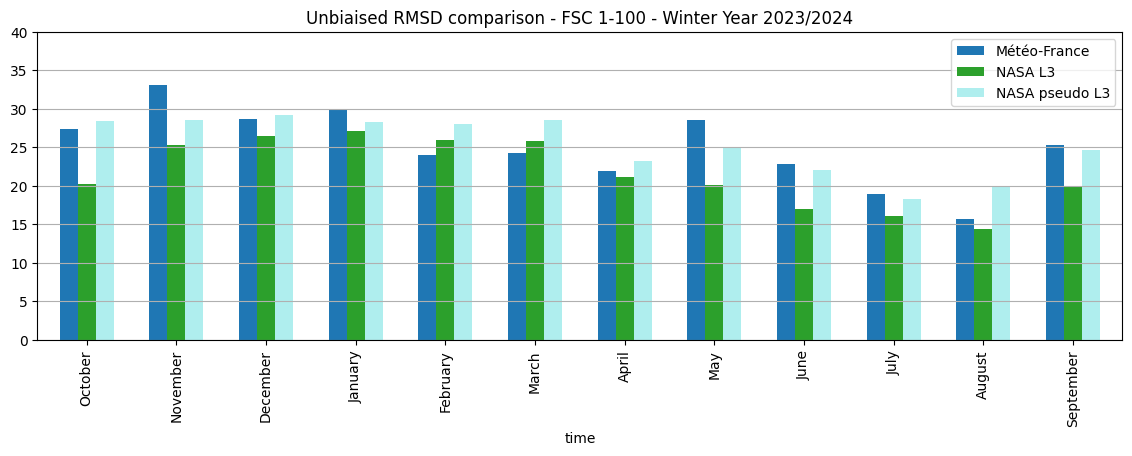

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

errors_fsc = xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_375m_errors_fsc.nc')*100


for fsc_class in ['all','0', '1-99','1-100']:
    errors_fsc_class = errors_fsc.data_vars['unbiased_RMSD'].sel(ref_fsc=fsc_class).sortby('time')
    df = pd.DataFrame({'Météo-France': errors_fsc_class.sel(product='Météo-France').to_pandas(), 
                        'NASA L3': errors_fsc_class.sel(product='NASA L3').to_pandas(),
                        'NASA pseudo L3': errors_fsc_class.sel(product='NASA pseudo L3').to_pandas()
                    })

    df.index = df.index.strftime("%B")
    df.plot.bar(figsize=(14,4), color=('tab:blue', 'tab:green','paleturquoise'), width=0.6, title=f'Unbiaised RMSD comparison - FSC {fsc_class} - Winter Year 2023/2024')
    plt.ylim([0,40])
    plt.grid(True,axis='y')

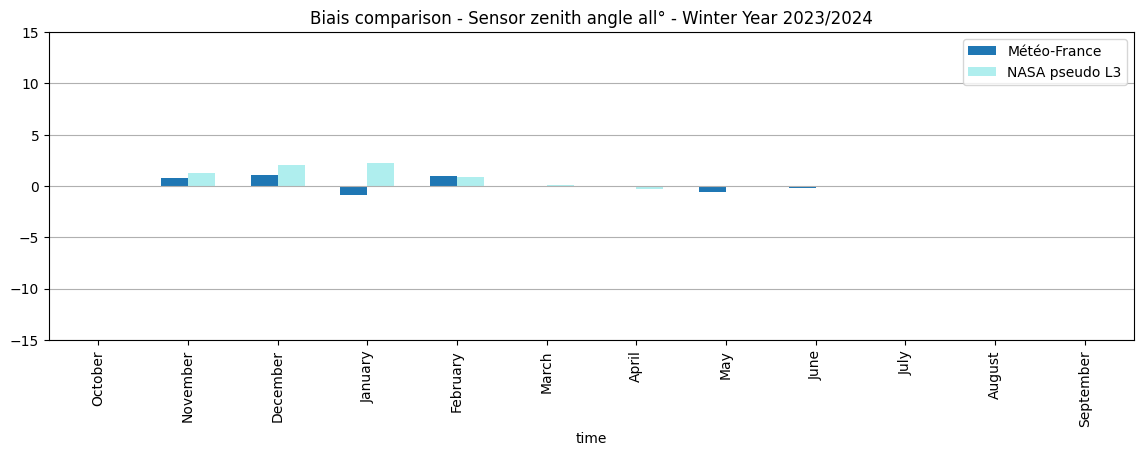

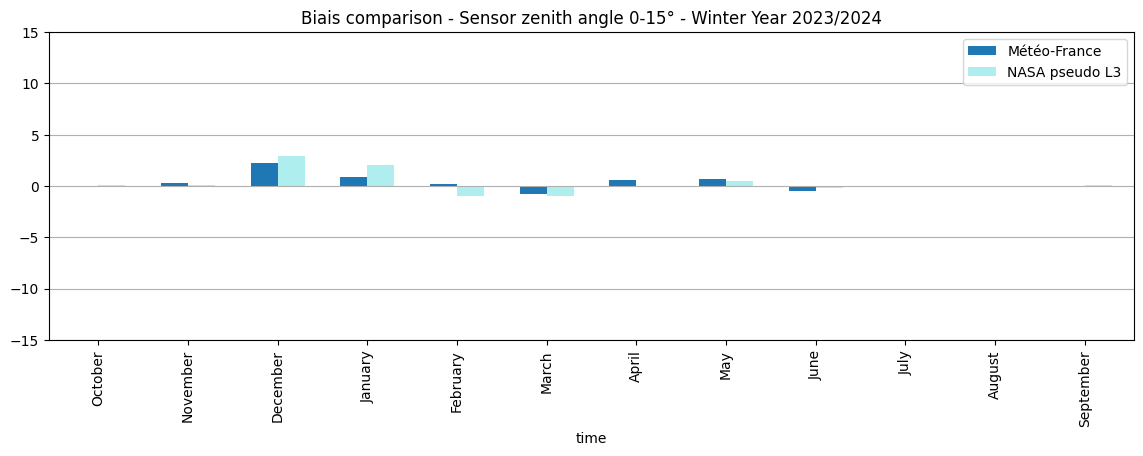

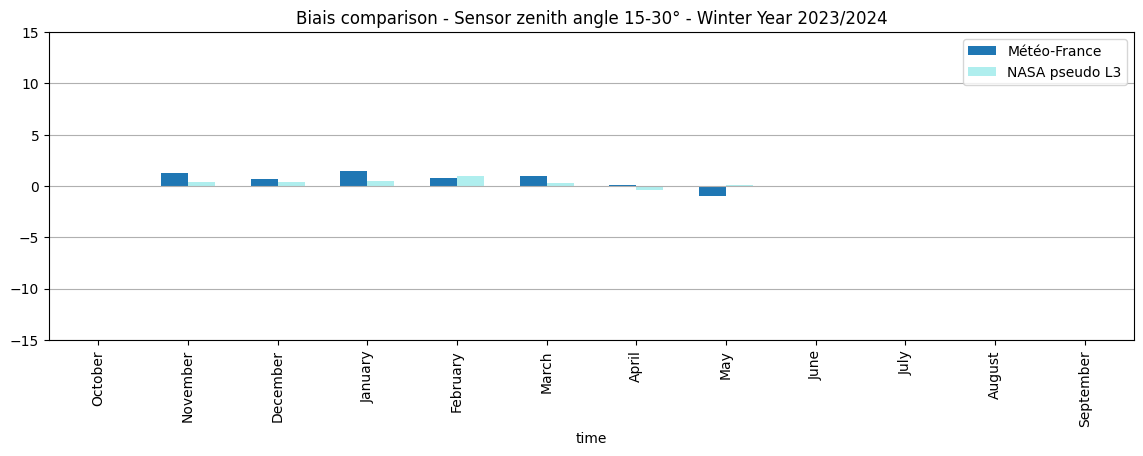

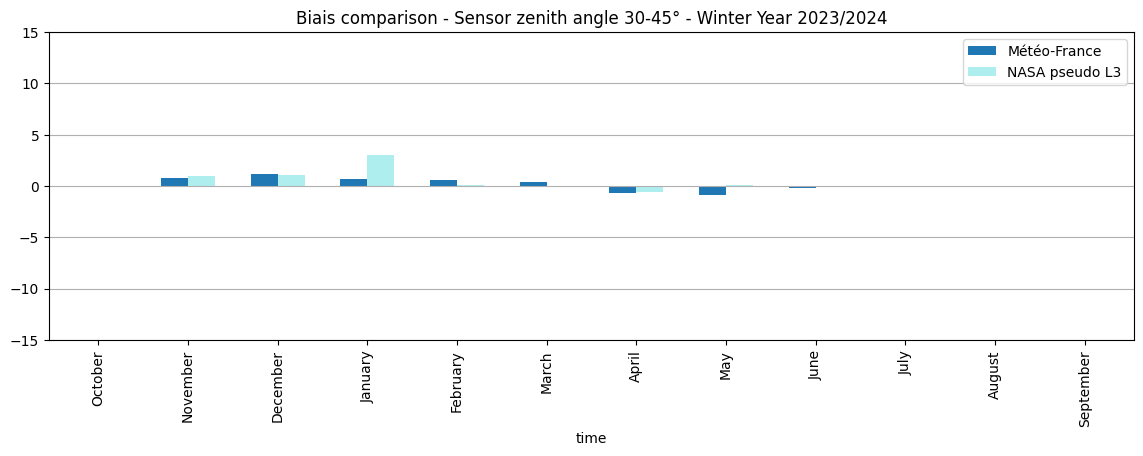

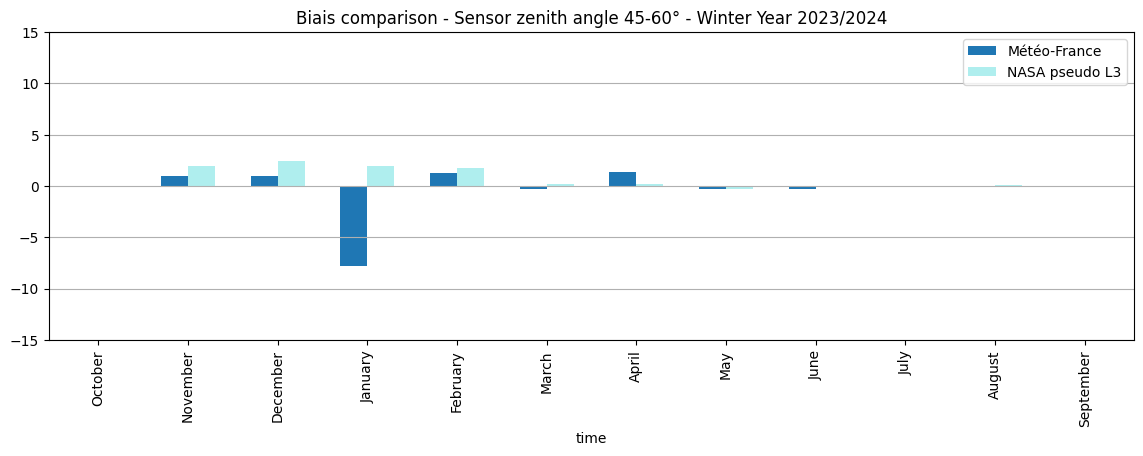

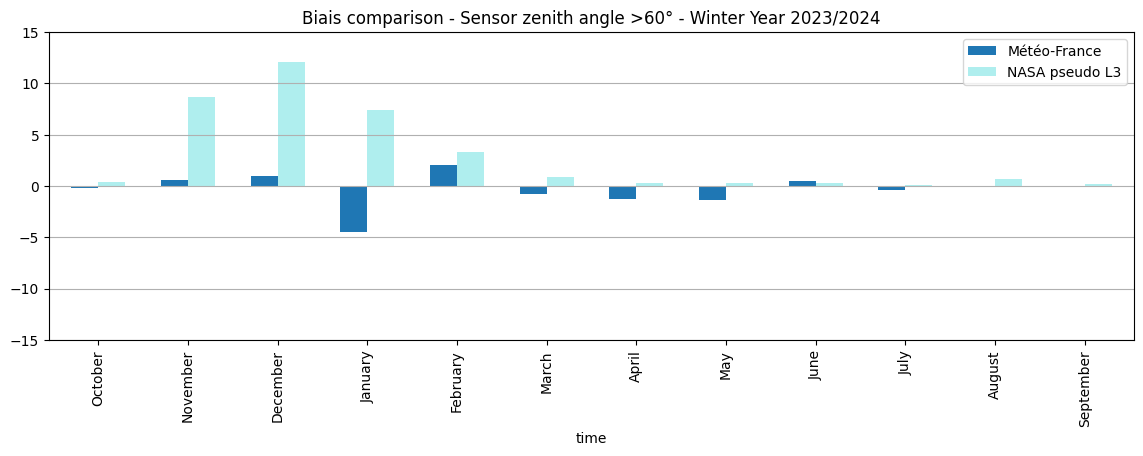

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

errors_vza = xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_375m_errors_vza.nc')*100


for sensor_class in ['all','0-15', '15-30','30-45','45-60','>60']:
    errors_vza_class = errors_vza.data_vars['biais'].sel(sensor_zenith=sensor_class).sortby('time')
    df = pd.DataFrame({'Météo-France': errors_vza_class.sel(product='Météo-France').to_pandas(), 
                        'NASA pseudo L3': errors_vza_class.sel(product='NASA pseudo L3').to_pandas()
                    })

    df.index = df.index.strftime("%B")
    df.plot.bar(figsize=(14,4), color=('tab:blue','paleturquoise'), width=0.6, title=f'Biais comparison - Sensor zenith angle {sensor_class}° - Winter Year 2023/2024')
    plt.ylim([-15,15])
    plt.grid(True,axis='y')

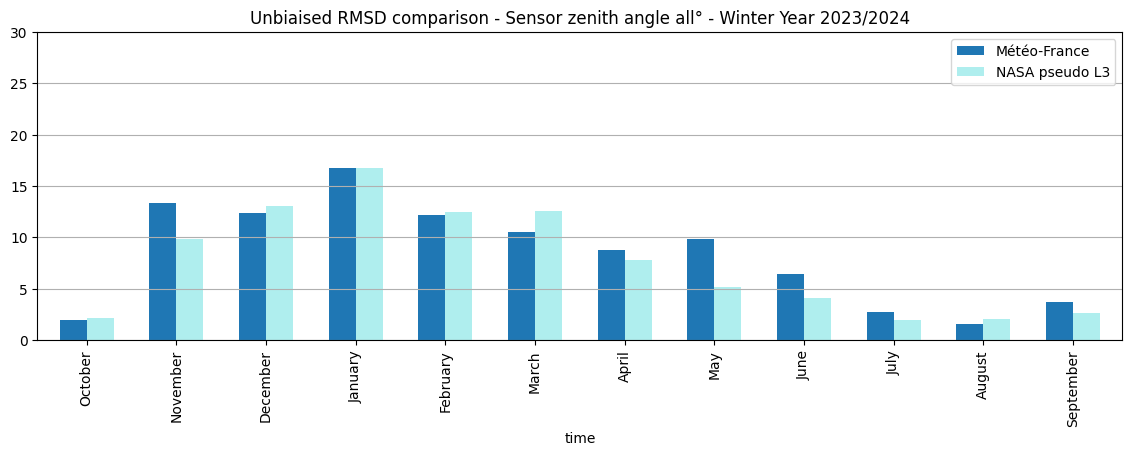

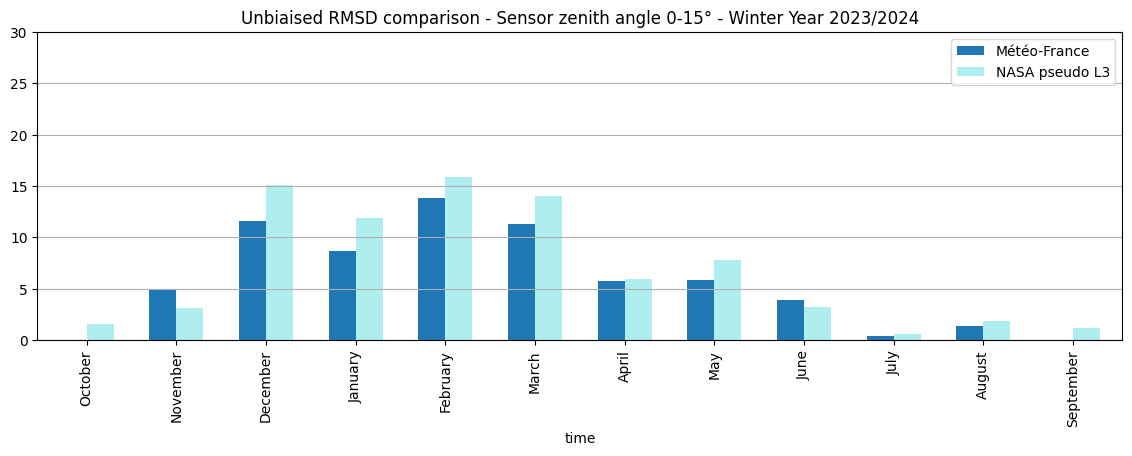

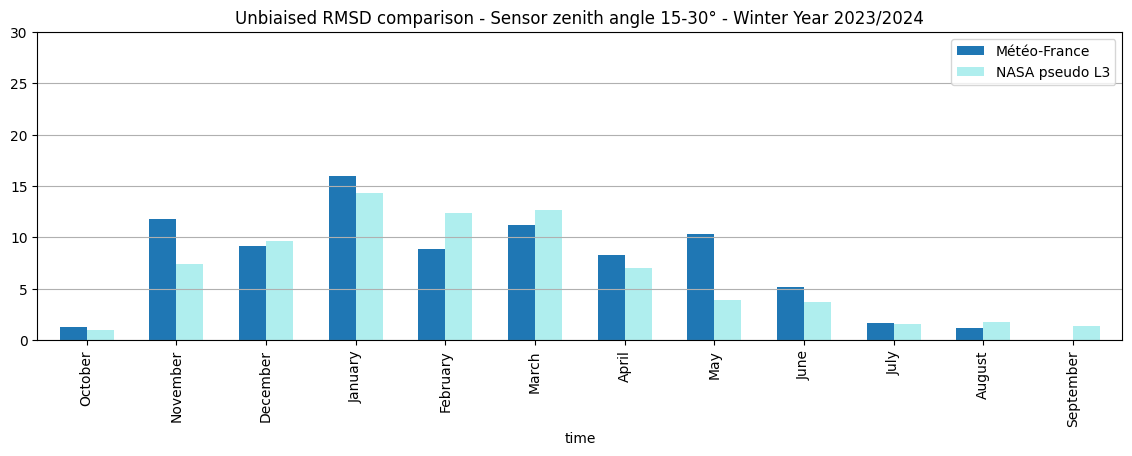

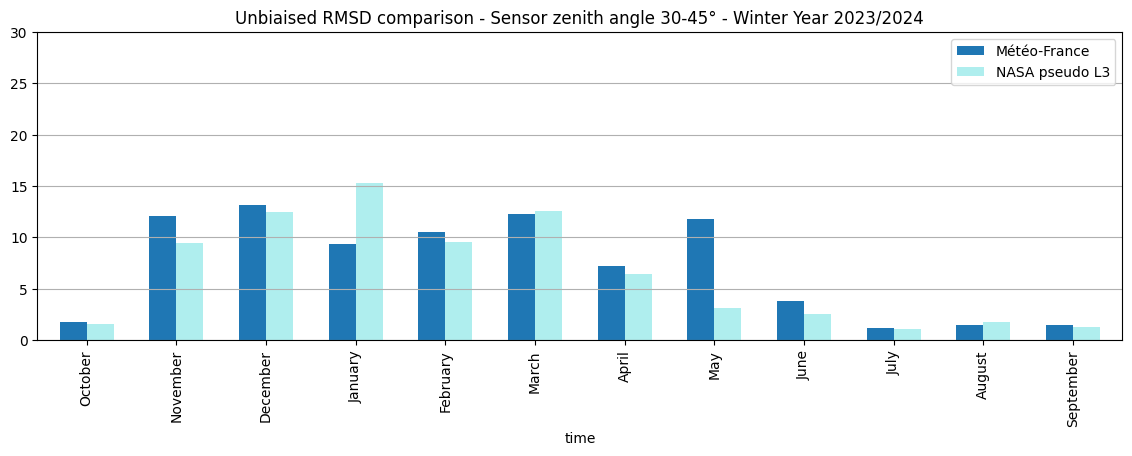

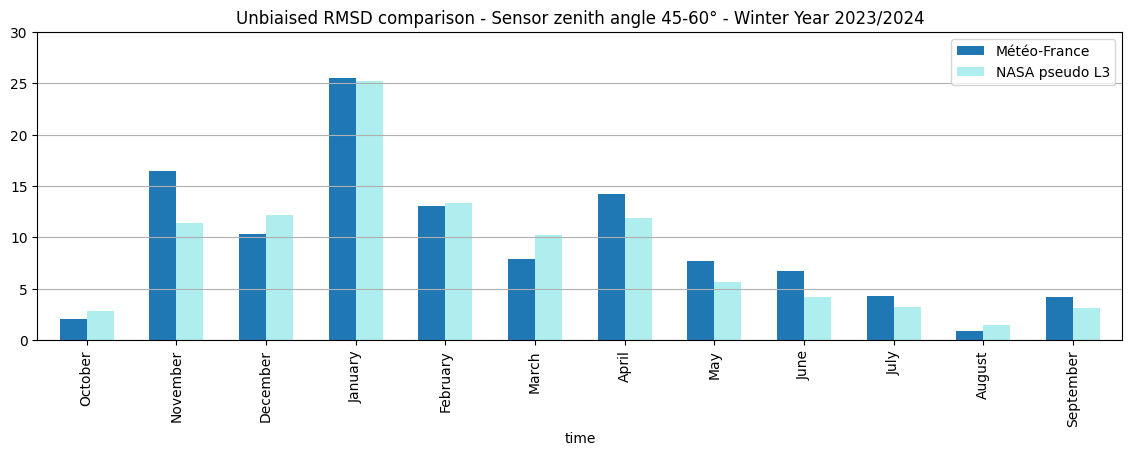

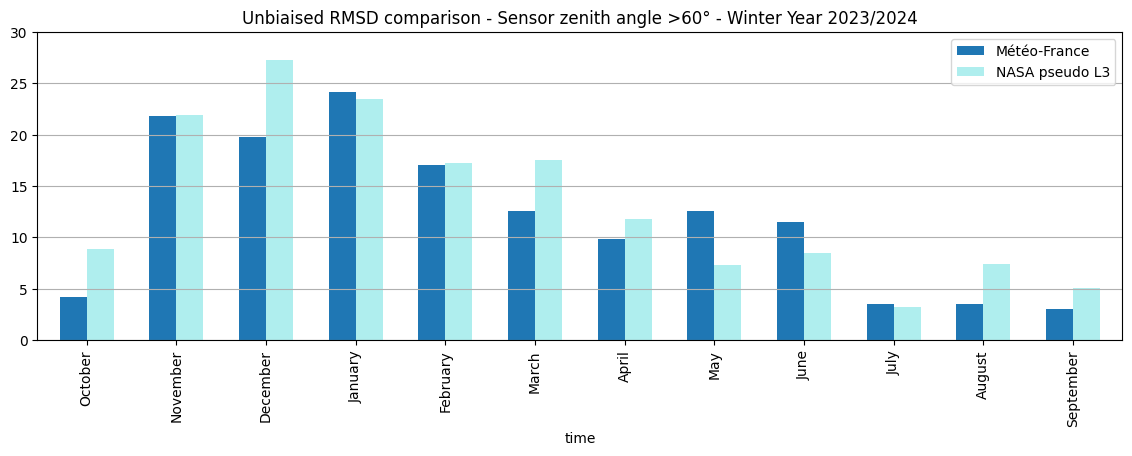

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

errors_vza = xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_375m_errors_vza.nc')*100


for sensor_class in ['all','0-15', '15-30','30-45','45-60','>60']:
    errors_vza_class = errors_vza.data_vars['unbiased_RMSD'].sel(sensor_zenith=sensor_class).sortby('time')
    df = pd.DataFrame({'Météo-France': errors_vza_class.sel(product='Météo-France').to_pandas(), 
                        'NASA pseudo L3': errors_vza_class.sel(product='NASA pseudo L3').to_pandas()
                    })

    df.index = df.index.strftime("%B")
    df.plot.bar(figsize=(14,4), color=('tab:blue','paleturquoise'), width=0.6, title=f'Unbiaised RMSD comparison - Sensor zenith angle {sensor_class}° - Winter Year 2023/2024')
    plt.ylim([0,30])
    plt.grid(True,axis='y')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

errors_vza = xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_375m_errors_vza_positive_fsc.nc')*100


for sensor_class in ['all','0-15', '15-30','30-45','45-60','>60']:
    errors_vza_class = errors_vza.data_vars['biais'].sel(sensor_zenith=sensor_class).sortby('time')
    df = pd.DataFrame({'Météo-France': errors_vza_class.sel(product='Météo-France').to_pandas(), 
                        'NASA pseudo L3': errors_vza_class.sel(product='NASA pseudo L3').to_pandas()
                    })

    df.index = df.index.strftime("%B")
    df.plot.bar(figsize=(14,4), color=('tab:blue','paleturquoise'), width=0.6, title=f'Biais comparison - Sensor zenith angle {sensor_class}° - Winter Year 2023/2024')
    plt.ylim([-15,15])
    plt.grid(True,axis='y')

In [9]:
xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_375m_errors_vza.nc')

<xarray.Dataset> Size: 3kB
Dimensions:        (time: 12, product: 2, sensor_zenith: 6)
Coordinates:
  * time           (time) datetime64[ns] 96B 2023-10-01 ... 2024-09-01
  * product        (product) <U14 112B 'Météo-France' 'NASA pseudo L3'
  * sensor_zenith  (sensor_zenith) <U5 120B '0-15' '15-30' ... '>60' 'all'
Data variables:
    biais          (time, product, sensor_zenith) float64 1kB ...
    unbiased_RMSD  (time, product, sensor_zenith) float64 1kB ...

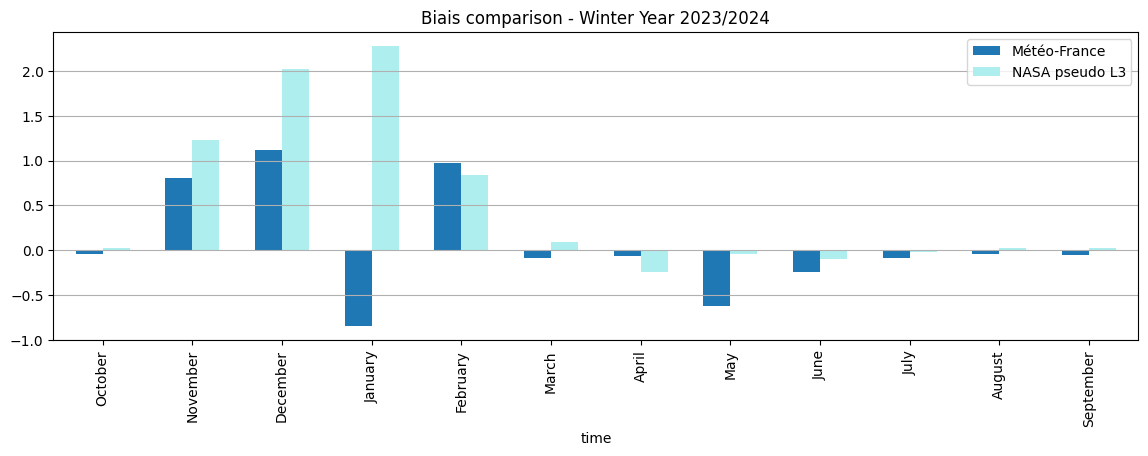

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

errors_fsc = xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_375m_errors_vza.nc')*100
errors_fsc = errors_fsc.data_vars['biais'].sel(sensor_zenith='all').sortby('time')

df = pd.DataFrame({'Météo-France': errors_fsc.sel(product='Météo-France').to_pandas(), 
                    'NASA pseudo L3': errors_fsc.sel(product='NASA pseudo L3').to_pandas()
                })

df.index = df.index.strftime("%B")
df.plot.bar(figsize=(14,4), color=('tab:blue', 'paleturquoise'), width=0.6, title='Biais comparison - Winter Year 2023/2024')
plt.grid(True,axis='y')

In [3]:
from typing import Dict

from products.classes import METEOFRANCE_CLASSES, NASA_CLASSES, S2_CLASSES


valid_ranges_dict = {'Sentinel-2': {'fsc_max': S2_CLASSES['snow_cover'][-1]},
                     'Météo-France': {'fsc_max': METEOFRANCE_CLASSES['snow_cover'][-1]},
                     'NASA L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]},
                     'NASA pseudo L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]}}

def compute_daily_bias_rmse_landcover(ref_time_series: Dict[str, xr.Dataset], time_series_to_compare: Dict[str, xr.Dataset], fsc_threshold: float = 0, forest_mask: xr.DataArray | None = None):

    time_coordinate = find_common_days(time_series_list=list(ref_time_series).extend(list(time_series_to_compare.values())))
    errors = xr.Dataset({'bias': xr.DataArray(np.nan, coords={'time':time_coordinate, 'product': time_series_to_compare.keys(), 'landcover': ['no_forest', 'forest', 'all']}),
                    'unbiased_RMSD': xr.DataArray(np.nan, coords={'time':time_coordinate, 'product': time_series_to_compare.keys(),'landcover': ['no_forest', 'forest', 'all']})})

    for day in time_coordinate:
        ref_snow_cover = ref_time_series.data_vars['snow_cover_fraction'].sel(time=day)
        ref_mask = ref_snow_cover  < valid_ranges_dict[ref_time_series.keys()[0]]['fsc_max'] & ref_snow_cover  >= fsc_threshold*valid_ranges_dict[ref_time_series.keys()[0]]['fsc max']
        ref_snow_cover = ref_snow_cover.where(ref_mask)
        for product_name, product in time_series_to_compare:
            product_snow_cover = product.data_vars['snow_cover_fraction'].sel(time=day)
            product_mask = product_snow_cover  < valid_ranges_dict[product_name]['fsc_max'] & ref_snow_cover  >= fsc_threshold*valid_ranges_dict[product_name]['fsc_max']
            product_snow_cover = product.where(product_mask)
            difference = product_snow_cover - ref_snow_cover
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais']['all'] = biais
            errors.data_vars['unbiased_RMSD']['all'] = rmse
            if forest_mask is not None:
                difference = product_snow_cover.where(forest_mask) - ref_snow_cover.where(forest_mask)
                biais, rmse = difference_array_to_bias_rmse(difference)
                errors.data_vars['biais']['forest'] = biais
                errors.data_vars['unbiased_RMSD']['forest'] = rmse
                difference = product_snow_cover.where(~forest_mask) - ref_snow_cover.where(~forest_mask)
                biais, rmse = difference_array_to_bias_rmse(difference)
                errors.data_vars['biais']['no_forest'] = biais
                errors.data_vars['unbiased_RMSD']['no_forest'] = rmse

    errors.to_netcdf(f'{time_series_folder}/WY_2023_2024_SNPP_errors_landcover.nc')

/tmp/ipykernel_7457/3997056545.py:12: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_7457/3997056545.py:14: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_7457/3997056545.py:12: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_7457/3997056545.py:14: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_7457/3997056545.py:12: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_7457/3997056545.py:14: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_7457/3997056545.py:12: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_7457/3997056545.py:14: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_7457/3997056545.py:12: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_7457

In [8]:
biases, rmses = [],[]
for day in common_days:
    mf_snow_forest_mask = meteofrance_time_series.data_vars['snow_cover'].sel(time=day) != 210
    nasa = nasa_time_series.data_vars['snow_cover'].sel(time=day) /100
    nasa_mask = nasa <=1
    s2 = s2_time_series.data_vars['snow_cover'].sel(time=day) / 100
    s2_mask = s2<=1
    nasa = nasa.where(nasa_mask).where(mf_snow_forest_mask)
    s2 =  s2.where(s2_mask)
    nasa = nasa.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)
    s2 = s2.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)
    diff = nasa - s2
    b = np.nanmean(diff)
    biases.append(b)
    rmses.append(np.sqrt(np.nanmean((diff- b)**2)))

errors_nasa_no_forest = xr.Dataset({'bias': xr.DataArray(biases, coords={'time':common_days}),
                    'rmse': xr.DataArray(rmses, coords={'time':common_days})})
errors_nasa_no_forest.to_netcdf('errors_nasa_no_forest_1km.nc')

/tmp/ipykernel_14573/4160990851.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/4160990851.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/4160990851.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/4160990851.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/4160990851.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/4160990851.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/4160990851.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/4160990851.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/4160990851.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipyke

In [7]:


biases, rmses = [],[]
for day in common_days:
    mf_snow_forest_mask = meteofrance_time_series.data_vars['snow_cover'].sel(time=day) == 210
    nasa = nasa_time_series.data_vars['snow_cover'].sel(time=day) /100
    nasa_mask = nasa <=1
    s2 = s2_time_series.data_vars['snow_cover'].sel(time=day) / 100
    s2_mask = s2<=1
    nasa = nasa.where(nasa_mask).where(mf_snow_forest_mask) 
    s2 = s2.where(s2_mask)
    nasa = nasa.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)
    s2 = s2.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)
    diff = nasa- s2
    b = np.nanmean(diff)
    biases.append(b)
    rmses.append(np.sqrt(np.nanmean((diff- b)**2)))

errors_nasa_forest = xr.Dataset({'bias': xr.DataArray(biases, coords={'time':common_days}),
                    'rmse': xr.DataArray(rmses, coords={'time':common_days})})
errors_nasa_forest.to_netcdf('errors_nasa_forest_1km.nc')

/tmp/ipykernel_14573/2832533926.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/2832533926.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/2832533926.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/2832533926.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/2832533926.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/2832533926.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/2832533926.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/2832533926.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/2832533926.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipyke

In [4]:

biases, rmses = [],[]
for day in common_days:
    mf = meteofrance_time_series.data_vars['snow_cover'].sel(time=day) /200
    mf_mask = mf <=1
    s2 = s2_time_series.data_vars['snow_cover'].sel(time=day) / 100
    s2_mask = s2<=1
    mf = mf.where(mf_mask) 
    s2 = s2.where(s2_mask)

    mf = mf.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)
    s2 = s2.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)
    
    diff = mf - s2
    b = np.nanmean(diff)

    biases.append(b)
    rmses.append(np.sqrt(np.nanmean((diff- b)**2)))

errors_mf = xr.Dataset({'bias': xr.DataArray(biases, coords={'time':common_days}),
                    'rmse': xr.DataArray(rmses, coords={'time':common_days})})
errors_mf.to_netcdf('errors_meteofrance_1km.nc')

/tmp/ipykernel_14573/382037027.py:14: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/382037027.py:17: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/382037027.py:14: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/382037027.py:17: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/382037027.py:14: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/382037027.py:17: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/382037027.py:14: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/382037027.py:17: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/382037027.py:14: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_1457

Comparison data resampled at 1 km cell size

In [4]:
errors_nasa = xr.open_dataset('errors_nasa_1km.nc')
errors_nasa_no_forest = xr.open_dataset('errors_nasa_no_forest_1km.nc')
errors_nasa_forest = xr.open_dataset('errors_nasa_forest_1km.nc')
errors_mf = xr.open_dataset('errors_meteofrance_1km.nc')

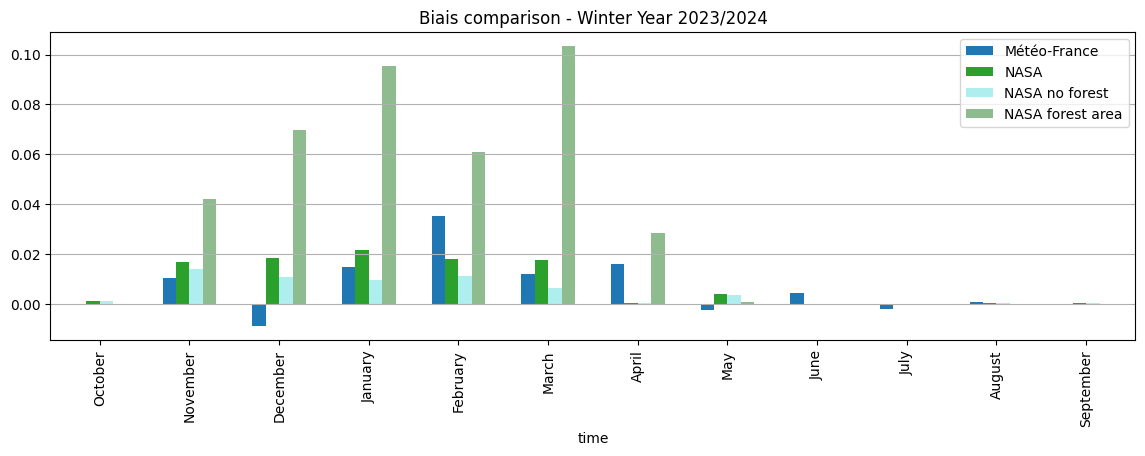

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
nasa_series = errors_nasa.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_no_forest_series = errors_nasa_no_forest.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
meteofrance_series = errors_mf.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_forest_series = errors_nasa_forest.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()

rmse_df = pd.DataFrame({ 'Météo-France': meteofrance_series, 'NASA': nasa_series,'NASA no forest': nasa_no_forest_series,'NASA forest area': nasa_forest_series})
rmse_df.index = rmse_df.index.strftime("%B")
rmse_df.plot.bar(figsize=(14,4), color=('tab:blue', 'tab:green','paleturquoise', 'darkseagreen'), width=0.6, title='Biais comparison - Winter Year 2023/2024')
plt.grid(True,axis='y')

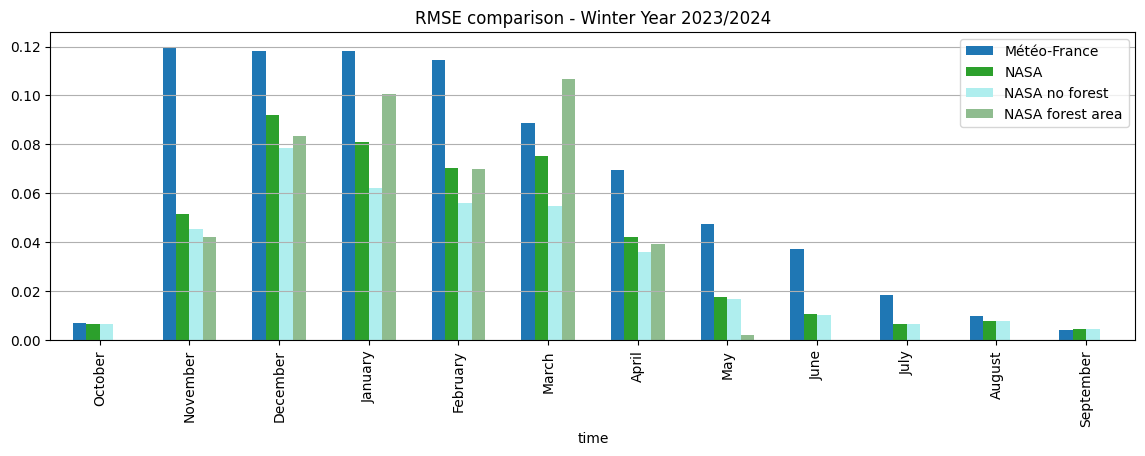

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
nasa_series = errors_nasa.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_no_forest_series = errors_nasa_no_forest.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
meteofrance_series = errors_mf.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_forest_series = errors_nasa_forest.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()

rmse_df = pd.DataFrame({ 'Météo-France': meteofrance_series, 'NASA': nasa_series,'NASA no forest': nasa_no_forest_series,'NASA forest area': nasa_forest_series})
rmse_df.index = rmse_df.index.strftime("%B")
rmse_df.plot.bar(figsize=(14,4), color=('tab:blue', 'tab:green','paleturquoise', 'darkseagreen'), width=0.6, title='RMSE comparison - Winter Year 2023/2024')
plt.grid(True,axis='y')

Comparison data at 250 m resolution

In [115]:
errors_nasa = xr.open_dataset('errors_nasa.nc')
errors_nasa_no_forest = xr.open_dataset('errors_nasa_no_forest.nc')
errors_nasa_forest = xr.open_dataset('errors_nasa_forest.nc')
errors_mf = xr.open_dataset('errors_meteofrance.nc')

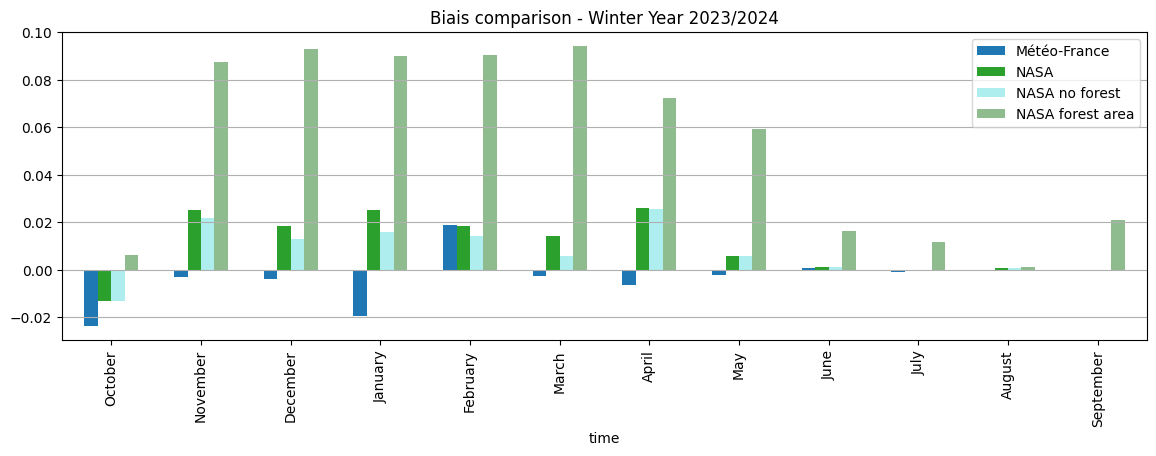

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
nasa_series = errors_nasa.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_no_forest_series = errors_nasa_no_forest.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
meteofrance_series = errors_mf.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_forest_series = errors_nasa_forest.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()

rmse_df = pd.DataFrame({ 'Météo-France': meteofrance_series, 'NASA': nasa_series,'NASA no forest': nasa_no_forest_series,'NASA forest area': nasa_forest_series})
rmse_df.index = rmse_df.index.strftime("%B")
rmse_df.plot.bar(figsize=(14,4), color=('tab:blue', 'tab:green','paleturquoise', 'darkseagreen'), width=0.6, title='Biais comparison - Winter Year 2023/2024')
plt.grid(True,axis='y')

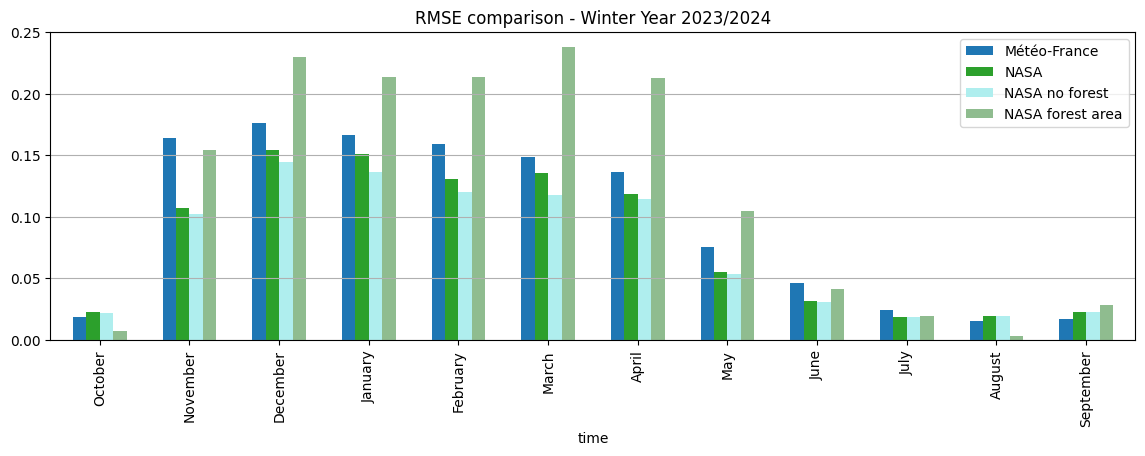

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
nasa_series = errors_nasa.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_no_forest_series = errors_nasa_no_forest.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
meteofrance_series = errors_mf.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_forest_series = errors_nasa_forest.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()

rmse_df = pd.DataFrame({ 'Météo-France': meteofrance_series, 'NASA': nasa_series,'NASA no forest': nasa_no_forest_series,'NASA forest area': nasa_forest_series})
rmse_df.index = rmse_df.index.strftime("%B")
rmse_df.plot.bar(figsize=(14,4), color=('tab:blue', 'tab:green','paleturquoise', 'darkseagreen'), width=0.6, title='RMSE comparison - Winter Year 2023/2024')
plt.grid(True,axis='y')